# Burgers Equation PINN

In [10]:
from kan import *

In [1]:
import torch
import sys
import matplotlib.pyplot as plt

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN
from utils import RAD_sampler, sample_collocation_points
from BurgerData import BurgerData

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup Boundary Value Problem

In [2]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 2, N_bc)
tR = torch.linspace(0, 2, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)

# All boundary conditions
Xbc = torch.cat((X0, XL, XR), dim=0)
Ubc = torch.cat((U0, uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [3]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 2, [0, -1], [2, 1])

In [4]:
# True solution
data = BurgerData()

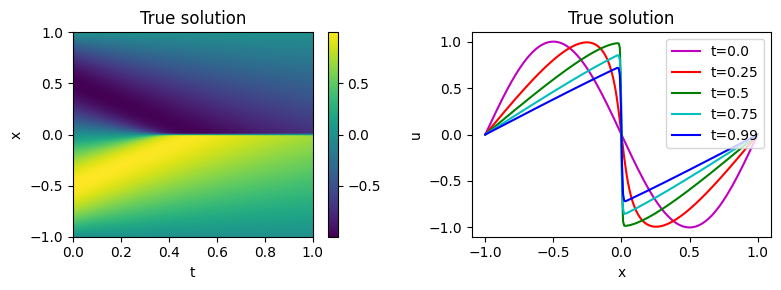

In [5]:
colors = ['m', 'r', 'g', 'c', 'b']

ax, fig = plt.subplots(1, 2, figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(data.usol, aspect='auto', extent=[0, 1, -1, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('True solution')

plt.subplot(1, 2, 2)
slices = [0, 25, 50, 75, 99]
for i in range(5):
    plt.plot(data.xsol, data.usol[:, slices[i]], label=f't={slices[i]/100}', color=colors[i])
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('True solution')

plt.tight_layout()
# Save a high quality figure
# plt.savefig('gfx/PINN_target_burgers.png', dpi=600)

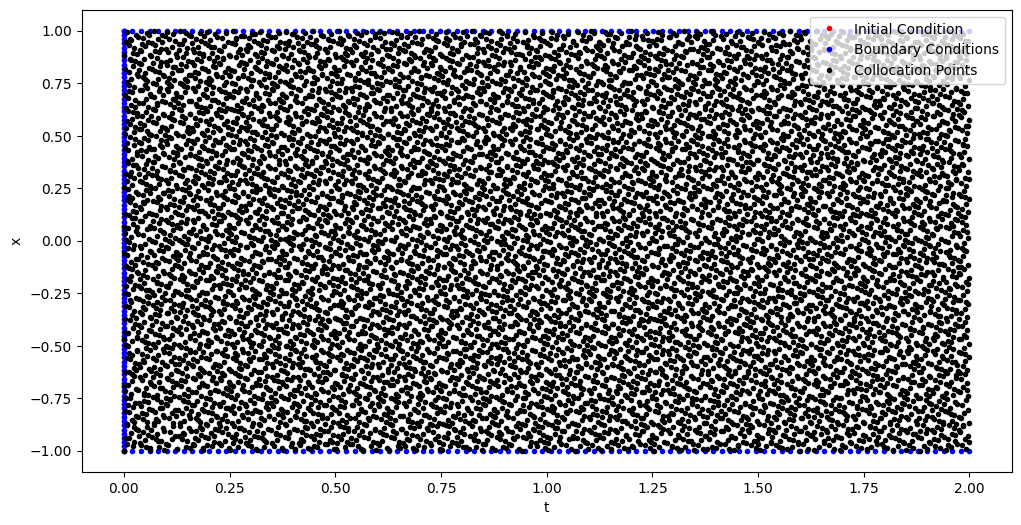

In [6]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Setup Boundary Value Problem

In [7]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t + u*u_x - self.nu*u_xx

### Initialize and train PINN

In [8]:
class UPINN_burger(UPINN):
    def score(self):

        L2_rel_err = torch.sqrt( torch.mean(((self.predict(data.data_points_full[0]) - data.data_points_full[1]))**2) / torch.mean((data.data_points_full[1])**2) )
        return L2_rel_err.item()

    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sample_collocation_points(N, 2, lb=[0, -1], ub=[1, 1])
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        residual = abs(self.N(Xc, u))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)
    


In [13]:
# Define model architecture
hidden = [20] * 8
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

nu = 0.01/torch.pi
N = Burger(nu)

# Instantiate the PINN
model = UPINN_burger(u, N, boundary_points=(Xbc, Ubc), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


[Info]: Training 100 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 100/100 [00:01<00:00, 50.48 epoch/s, bc_loss=1.05e-05, data_loss=0.00e+00, pde_loss=6.67e-05, loss=7.72e-05]


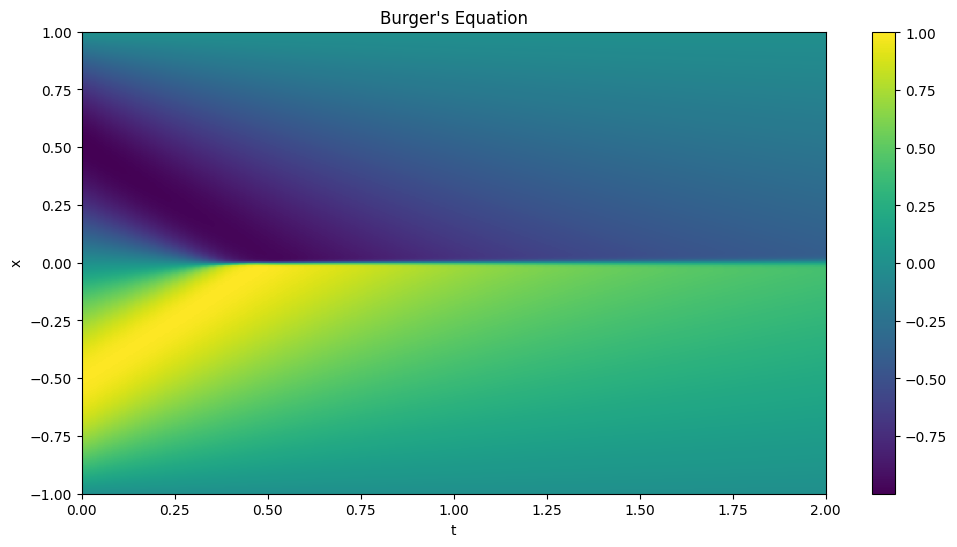

In [ ]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-4)
lbfgs = torch.optim.LBFGS(model.parameters())

for _ in range(1):
    model.optimizer = adamw
    model.train_loop(100)
    # model.optimizer = lbfgs
    # model.train_loop(100)
    # model.refine_collocation_points()

    # Compute the solution
    T, X = torch.meshgrid(torch.linspace(0, 2, 100), torch.linspace(-1, 1, 256))
    X_star = torch.stack((T.flatten(), X.flatten()), dim=1)
    u_pred = model.predict(X_star).detach().numpy().reshape(100, 256)

    # Plot the solution
    plt.figure(figsize=(12, 6))
    plt.imshow(u_pred.T, aspect='auto', extent=[0, 2, -1, 1], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Burger\'s Equation')
    plt.show()


In [ ]:
u2 = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)
model2 = UPINN_burger(u2, N, boundary_points=(Xbc, Ubc), collocation_points=Xc)
name = 'burger_pinn_extrapolate'
model2.load(name, 'models')

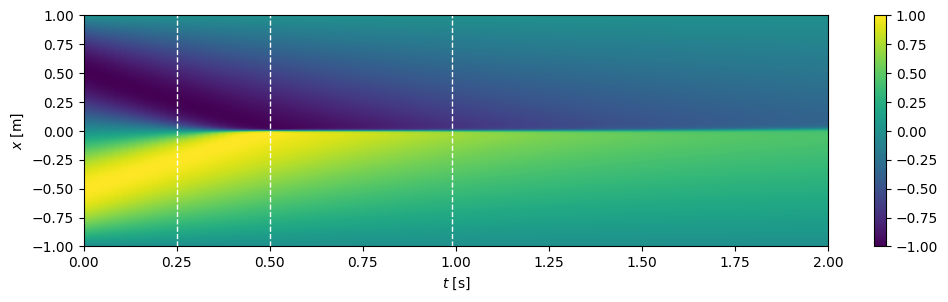

In [79]:
model.to('cpu')
T, X = torch.meshgrid(torch.linspace(0, 2, 100), torch.linspace(-1, 1, 256))
X_plot = torch.stack((T.flatten(), X.flatten()), dim=-1)
U_plot = model2.u(X_plot).reshape(100, 256).detach().numpy()

plt.figure(figsize=(12, 3))
plt.imshow(U_plot.T, extent=(0, 2, -1, 1), origin='lower', aspect='auto', vmin=-1, vmax=1)
for slice in [0.25, 0.5, 0.99]:
    plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
plt.plot
plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')
plt.colorbar()
plt.savefig('gfx/burger_pinn_extended_solution.pdf', format='pdf', bbox_inches='tight')
plt.show()

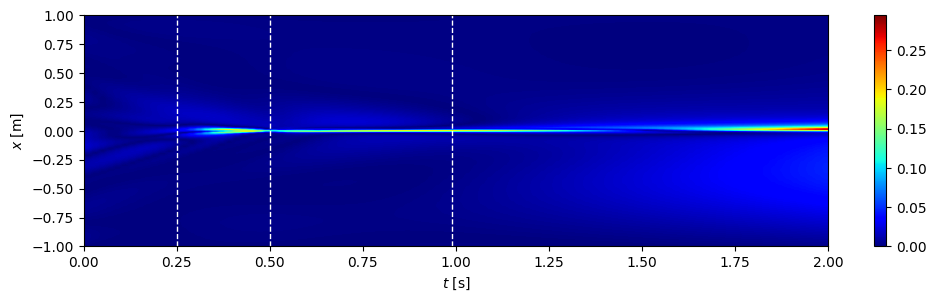

In [80]:
model.to('cpu')
T, X = torch.meshgrid(torch.linspace(0, 2, 100), torch.linspace(-1, 1, 256))
X_plot = torch.stack((T.flatten(), X.flatten()), dim=-1)
U_plot = model.u(X_plot).reshape(100, 256).detach().numpy()
U_true = model2.u(X_plot).reshape(100, 256).detach().numpy()

plt.figure(figsize=(12, 3))
plt.imshow(abs(U_true.T-U_plot.T), extent=(0, 2, -1, 1), origin='lower', aspect='auto', vmin=0, cmap='jet')
for slice in [0.25, 0.5, 0.99]:
    plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
plt.plot
plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')
plt.colorbar()
plt.savefig('gfx/burger_pinn_extended_error.pdf', format='pdf', bbox_inches='tight')
plt.show()